# Spatial reconstruction of the mouse embryo

In this notebook present spatial reconstruction of the mouse embryo with SageNet. We use the seqFISH dataset collected by [Lohoff et al. (2022)](https://www.nature.com/articles/s41587-021-01006-2) as the spatial reference. This Spatial Mouse Atlas dataset contains barcoded gene expression measurements for 351 genes in three distinct mouse embryo sagittal sections. We also use combination of a subset of this dataset and the dissociated scRNAseq mouse gastrulation atlas by [Pijuan-Sala et al. (2019)](https://pubmed.ncbi.nlm.nih.gov/30787436/) as the query dataset. For both spatial and scRNAseq datasets, we focus on embryonic day (E)8.5. 

We specifically show how one could aggeregate multiple spatial references and build an ensemble SageNet model. 


## Setup

### Installing pytorch geometric

We install [pytorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/) and its requirments as instructed [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html 
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html 
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git 

     |████████████████████████████████| 7.9 MB 8.3 MB/s 
     |████████████████████████████████| 3.5 MB 10.4 MB/s 


### Installing SageNet via GitHub
To install the dev. version of SageNet, we install it via GitHub.

In [ ]:
!pip install git+https://github.com/MarioniLab/sagenet

In [ ]:
!pip install pyyaml==5.4.0 # just to handle requirements for squidpy on google colab

  Using cached PyYAML-5.4-cp37-cp37m-manylinux1_x86_64.whl (636 kB)
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install squidpy --no-cache-dir

### Loading the libraries

In [ ]:
import sagenet as sg
import scanpy as sc # for plotting 
import anndata as ad # for handling the datasets
import random # for setting a random seed 
import numpy as np 
import copy
from matplotlib import *
import squidpy as sq
import pandas as pd

### Auxiliary functions and static values

In [ ]:
celltype_colours = {
  "Epiblast" : "#635547",
  "Primitive Streak" : "#DABE99",
  "Caudal epiblast" : "#9e6762",
  "PGC" : "#FACB12",
  "Anterior Primitive Streak" : "#c19f70",
  "Notochord" : "#0F4A9C",
  "Def. endoderm" : "#F397C0",
  "Definitive endoderm" : "#F397C0",
  "Gut" : "#EF5A9D",
  "Gut tube" : "#EF5A9D",
  "Nascent mesoderm" : "#C594BF",
  "Mixed mesoderm" : "#DFCDE4",
  "Intermediate mesoderm" : "#139992",
  "Caudal Mesoderm" : "#3F84AA",
  "Paraxial mesoderm" : "#8DB5CE",
  "Somitic mesoderm" : "#005579",
  "Pharyngeal mesoderm" : "#C9EBFB",
  "Splanchnic mesoderm" : "#C9EBFB",
  "Cardiomyocytes" : "#B51D8D",
  "Allantois" : "#532C8A",
  "ExE mesoderm" : "#8870ad",
  "Lateral plate mesoderm" : "#8870ad",
  "Mesenchyme" : "#cc7818",
  "Mixed mesenchymal mesoderm" : "#cc7818",
  "Haematoendothelial progenitors" : "#FBBE92",
  "Endothelium" : "#ff891c",
  "Blood progenitors 1" : "#f9decf",
  "Blood progenitors 2" : "#c9a997",
  "Erythroid1" : "#C72228",
  "Erythroid2" : "#f79083",
  "Erythroid3" : "#EF4E22",
  "Erythroid" : "#f79083",
  "Blood progenitors" : "#f9decf",
  "NMP" : "#8EC792",
  "Rostral neurectoderm" : "#65A83E",
  "Caudal neurectoderm" : "#354E23",
  "Neural crest" : "#C3C388",
  "Forebrain/Midbrain/Hindbrain" : "#647a4f",
  "Spinal cord" : "#CDE088",
  "Surface ectoderm" : "#f7f79e",
  "Visceral endoderm" : "#F6BFCB",
  "ExE endoderm" : "#7F6874",
  "ExE ectoderm" : "#989898",
  "Parietal endoderm" : "#1A1A1A",
  "Unknown" : "#FFFFFF",
  "Low quality" : "#e6e6e6",
  # somitic and paraxial types
  # colour from T chimera paper Guibentif et al Developmental Cell 2021
  "Cranial mesoderm" : "#77441B",
  "Anterior somitic tissues" : "#F90026",
  "Sclerotome" : "#A10037",
  "Dermomyotome" : "#DA5921",
  "Posterior somitic tissues" : "#E1C239",
  "Presomitic mesoderm" : "#9DD84A"
}

## The seqFISH reference datasets
[Lohoff et al. (2022)](https://www.nature.com/articles/s41587-021-01006-2) carried out a SeqFISH experiment on sagittal sections from three mouse embryos corresponding to embryonic day (E)8.5–8.75 to quantify spatial gene expression at single cell resolution of a pre-selected set of 387 genes. For each embryo section, they captured two 2D planes, 12um apart, yielding a total of 6 spatially-resolved sections. The authors performed cell segmentation, quantified gene expression log-counts, and assigned cell type identities to each cell using a large-scale single cell study of mouse gastrulation [Pijuan-Sala et al. (2019)](https://pubmed.ncbi.nlm.nih.gov/30787436/) as a reference.

This dataset is ideal for evaluating SageNet in comparison with other methods, since we have access to ground truth spatial coordinates for individual cells over multiple biological replicates, and the tissue structure observed across mouse embryos are varied and complex. We downloaded the gene expression matrix and cell type and spatial location metadata from https://content.cruk.cam.ac.uk/jmlab/SpatialMouseAtlas2020/. Prior to analysis, we removed cells that were annotated as “Low quality” by the authors. 

The seqFISH datsets could be simply downloaded and loaded in the environment by calling `sg.MGA_data.seqFISH{embryo}_{layer}()`.

We use the SeqFISH samples “embryo 1 layer 1” (`embryo1_2`), “embryo 2 layer 1” (`embryo2_2`), and “embryo 3 layer 1” (`embryo3_2`) as spatial references. 

In [ ]:
from copy import copy
adata_r1 = sg.MGA_data.seqFISH1_1()
adata_r2 = sg.MGA_data.seqFISH2_1()
adata_r3 = sg.MGA_data.seqFISH3_1()

  0%|          | 0.00/15.0M [00:00<?, ?B/s]

  0%|          | 0.00/11.3M [00:00<?, ?B/s]

  0%|          | 0.00/16.3M [00:00<?, ?B/s]

### Constructing the gene interaction network and spatial partitioning

We used the graphical LASSO (GLASSO) approach to estimate the gene interaction network. To extract multiple spatial partitionings for each SeqFISH sample, we obtain a spatial kNN graph using the implementation in squidpy, and perform Leiden clustering on the graph with resolutions 0.05, 0.1, and  0.5. For each SeqFISH sample and partitioning, we fitted a SageNet model. 

In [ ]:
%%time
from sagenet.utils import glasso
import numpy as np
glasso(adata_r1, [0.25, 0.5])
adata_r1.obsm['spatial'] = np.array(adata_r1.obs[['x','y']])
sq.gr.spatial_neighbors(adata_r1, coord_type="generic")
sc.tl.leiden(adata_r1, resolution=.05, random_state=0, key_added='leiden_0.05', adjacency=adata_r1.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r1, resolution=.1, random_state=0, key_added='leiden_0.1', adjacency=adata_r1.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r1, resolution=.5, random_state=0, key_added='leiden_0.5', adjacency=adata_r1.obsp["spatial_connectivities"])
glasso(adata_r2, [0.25, 0.5])
adata_r2.obsm['spatial'] = np.array(adata_r2.obs[['x','y']])
sq.gr.spatial_neighbors(adata_r2, coord_type="generic")
sc.tl.leiden(adata_r2, resolution=.05, random_state=0, key_added='leiden_0.05', adjacency=adata_r2.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r2, resolution=.1, random_state=0, key_added='leiden_0.1', adjacency=adata_r2.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r2, resolution=.5, random_state=0, key_added='leiden_0.5', adjacency=adata_r2.obsp["spatial_connectivities"])
glasso(adata_r3, [0.25, 0.5])
adata_r3.obsm['spatial'] = np.array(adata_r3.obs[['x','y']])
sq.gr.spatial_neighbors(adata_r3, coord_type="generic")
sc.tl.leiden(adata_r3, resolution=.05, random_state=0, key_added='leiden_0.05', adjacency=adata_r3.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r3, resolution=.1, random_state=0, key_added='leiden_0.1', adjacency=adata_r3.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r3, resolution=.5, random_state=0, key_added='leiden_0.5', adjacency=adata_r3.obsp["spatial_connectivities"])

CPU times: user 23.8 s, sys: 13.5 s, total: 37.3 s
Wall time: 21 s


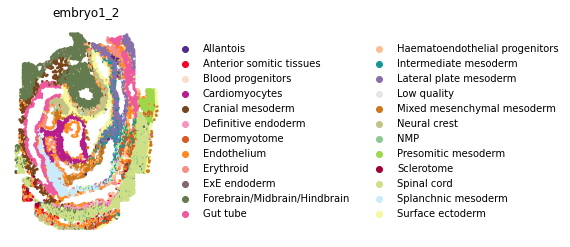

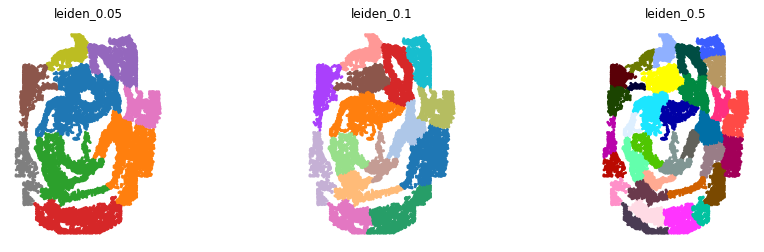

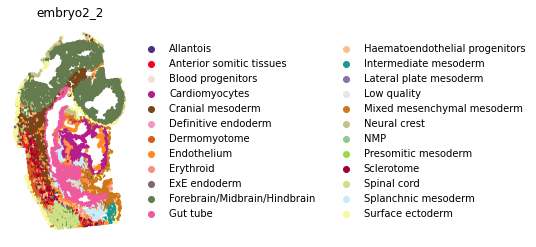

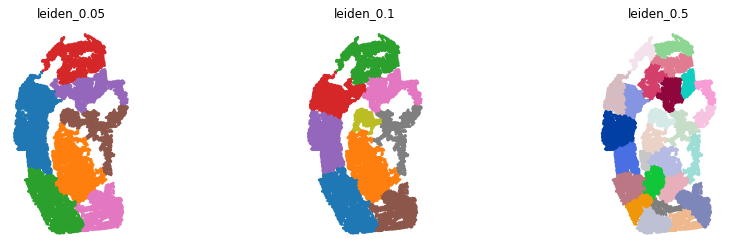

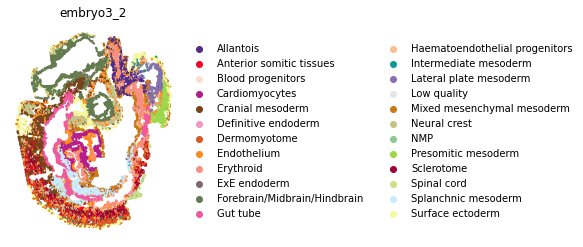

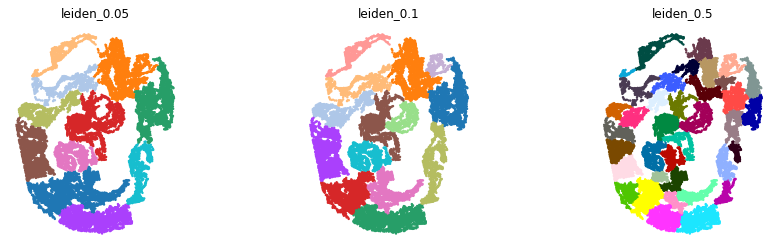

In [ ]:
for adata in [adata_r1, adata_r2, adata_r3]:
  with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.spatial(adata, color='cell_type', palette=celltype_colours, frameon=False, ncols=4, spot_size=.1, title=pd.unique(adata.obs['embryo']))
    sc.pl.spatial(adata, color=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'], frameon=False, ncols=3, spot_size=.1, title=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'], legend_loc=None)

## Training the models

### Instantiating the `sage` object
First, we instantiate a `sage` object to store the parameters and the trained models in the upcoming steps.

In [ ]:
import torch
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)
print(device)
sg_obj = sg.sage.sage(device=device)

cpu


### Training on multiple spatial references

We append SageNet models across various partionings to generate ensemble SageNet models for each SeqFISH sample, which we named according to the sample. We also appended all models trained on the three embryo sections to generate an ensemble SageNet model. 

In [ ]:
%time sg_obj.add_ref(adata_r1, comm_columns=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'], tag='seqFISH_ref1', epochs=15, verbose = False)
%time sg_obj.add_ref(adata_r2, comm_columns=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'], tag='seqFISH_ref2', epochs=15, verbose = False)
%time sg_obj.add_ref(adata_r3, comm_columns=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'], tag='seqFISH_ref3', epochs=15, verbose = False)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


CPU times: user 6min 57s, sys: 8.28 s, total: 7min 5s
Wall time: 7min 3s


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


CPU times: user 7min 9s, sys: 14 s, total: 7min 23s
Wall time: 7min 21s


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


CPU times: user 9min 12s, sys: 20.9 s, total: 9min 33s
Wall time: 9min 31s


### Interpreting the trained models to extract the spatially informative genes

The most important features of a trained SageNet model can be extracted using [the integrated gradients](https://captum.ai/docs/extension/integrated_gradients) technique. These genes can be interpreted as genes that are required for the accurate prediction of spatial partitions, and can be associated with specific partitions either in terms of presence of gene expression or importantly an absence of expression. 

The gene importance values are computed and stored, automatically, in the reference dataset by runing the `add_ref` function. In the following chunk, we extract the genes which have been the most important gene in classifying cells into at least one partition in at least one partitioning (for at least one reference dataset):

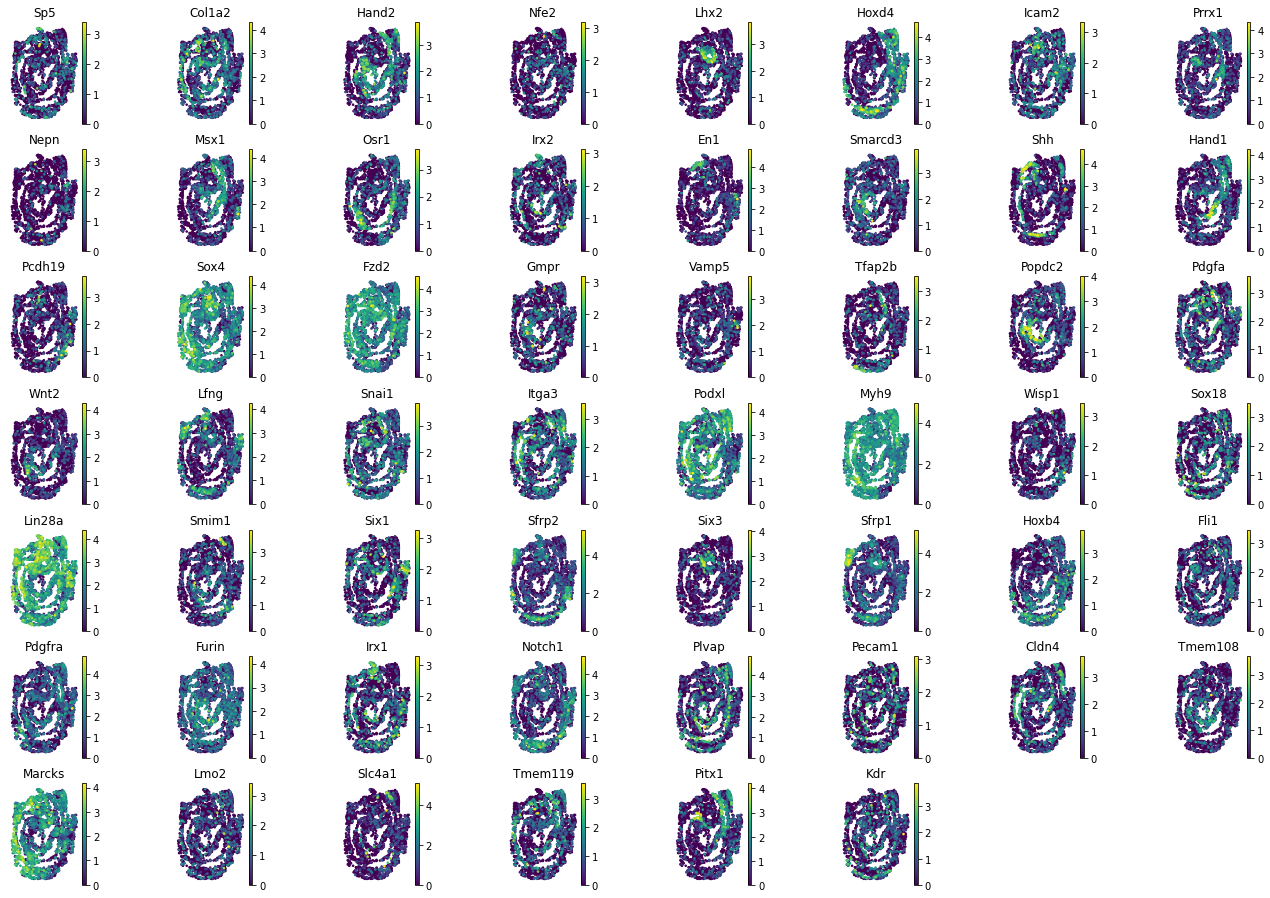

In [ ]:
from copy import copy
ind   = np.where(adata_r1.var['seqFISH_ref1_importance'] == 0)[0]
SIGs1 = list(adata_r1.var_names[ind])
ind   = np.where(adata_r2.var['seqFISH_ref2_importance'] == 0)[0]
SIGs2 = list(adata_r2.var_names[ind])
ind   = np.where(adata_r3.var['seqFISH_ref3_importance'] == 0)[0]
SIGs3 = list(adata_r3.var_names[ind])
SIGs  = list(set(SIGs1) | set(SIGs2) | set(SIGs3))
adata_r = copy(adata_r1)
sc.pp.subsample(adata_r, fraction=0.25)
with rc_context({'figure.figsize': (2, 2)}):
  sc.pl.spatial(adata_r, color=SIGs, ncols=8, spot_size=0.2, legend_loc=None, frameon=False)

### Storing and reusing the trained SageNet models
The trained SageNet model (as stored in the `sg_obj`) can be stored as a folder, and then restored again for later use:

In [ ]:
!mkdir models
!mkdir models/seqFISH_ref
sg_obj.save_model_as_folder('models/seqFISH_ref')
sg_obj.load_model_as_folder('models/seqFISH_ref')

/usr/local/lib/python3.7/dist-packages/sagenet/sage.py:202: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adj_adata = anndata.AnnData(X = self.adjs[tag])


## Spatial reconstruction of the query dataset

We then proceed to perform spatial reconstruction of a dissociated single-cell dataset using the abovementioned ensemble SageNet model. Using a representative random subsample of 20% of cells from the dissociated scRNA-seq mouse gastrulation atlas, at embryonic day (E)8.5 (Pijuan-Sala et al. 2019), alongside a random subset of 20% cells from the seqFISH layer 2, we generated a spatial reconstruction). 


In [ ]:
adata_q1 = sg.MGA_data.seqFISH1_2()
adata_q2 = sg.MGA_data.seqFISH2_2()
adata_q3 = sg.MGA_data.seqFISH3_2()
adata_q4 = sg.MGA_data.scRNAseq()
adata_q4.obs['embryo'] = 'scRNAseq'
sc.pp.subsample(adata_q1, fraction=0.2)
sc.pp.subsample(adata_q2, fraction=0.2)
sc.pp.subsample(adata_q3, fraction=0.2)
sc.pp.subsample(adata_q4, fraction=0.2)
adata_q = ad.concat([adata_q1, adata_q2, adata_q3, adata_q4], join="inner")
del adata_q1 
del adata_q2 
del adata_q3 
del adata_q4

  0%|          | 0.00/10.9M [00:00<?, ?B/s]

  0%|          | 0.00/9.32M [00:00<?, ?B/s]

  0%|          | 0.00/13.1M [00:00<?, ?B/s]

  0%|          | 0.00/25.8M [00:00<?, ?B/s]

### Mapping the query dataset

In [ ]:
%time sg_obj.map_query(adata_q)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


CPU times: user 2min 19s, sys: 6.98 s, total: 2min 26s
Wall time: 2min 22s


### Predicted distance matrix and low-dimentional embedding of query cells
Once the ensemble SageNet model is trained, a probability vector is estimated for each query cell, corresponding to each spatial partitioning. A spatial cell-to-cell distance matrix is calculated using the [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence). `map_query` function computes such a cell-to-cell  distance matrix and stores in `obsm` with key `dist_map`. The predicted cell-to-cell distance matrix is then used to embed the query cells in a 2 or 3-dimensional space (using e.g., `t-SNE`); this low-dimensional space represents the SageNet spatial reconstruction.

In [ ]:
dist_adata = ad.AnnData(adata_q.obsm['dist_map'], obs = adata_q.obs)
knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap(dist_adata.X, n_neighbors=50, metric='precomputed')
dist_adata.obsp['distances'], dist_adata.obsp['connectivities'] = sc.neighbors._compute_connectivities_umap(
    knn_indices,
    knn_dists,
    dist_adata.shape[0],
    50 # change to neighbors you plan to use
)
sc.pp.neighbors(dist_adata, metric='precomputed', use_rep='X')
sc.tl.tsne(dist_adata)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


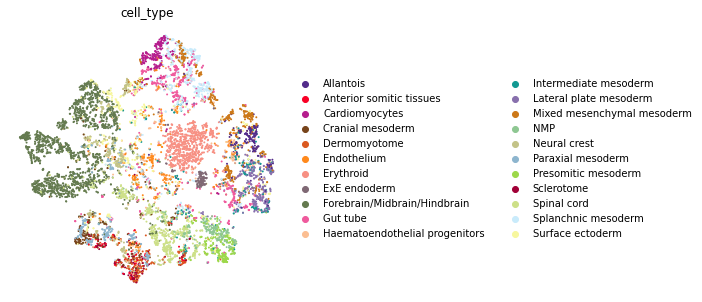

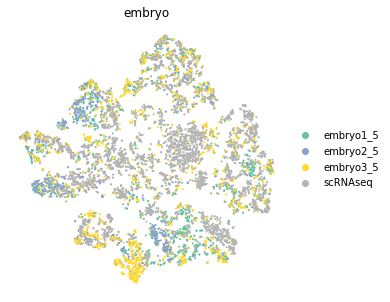

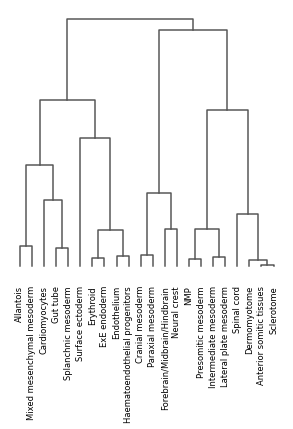

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
  sc.pl.tsne(dist_adata, color=['cell_type'], palette=celltype_colours,  save='mouse_embryo_SageNet_reconstructed.pdf', frameon=False)
  sc.pl.tsne(dist_adata, color='embryo', palette='Set2', frameon=False)
  ax = sc.pl.dendrogram(dist_adata, 'cell_type')

In [ ]:
cluster_counts = adata_q.obs['cell_type'].value_counts()
adata_q = adata_q[adata_q.obs['cell_type'].isin( cluster_counts[cluster_counts>50].index)]
dist_adata = dist_adata[dist_adata.obs['cell_type'].isin( cluster_counts[cluster_counts>50].index)]

We can look at the expression of SIGs once again:


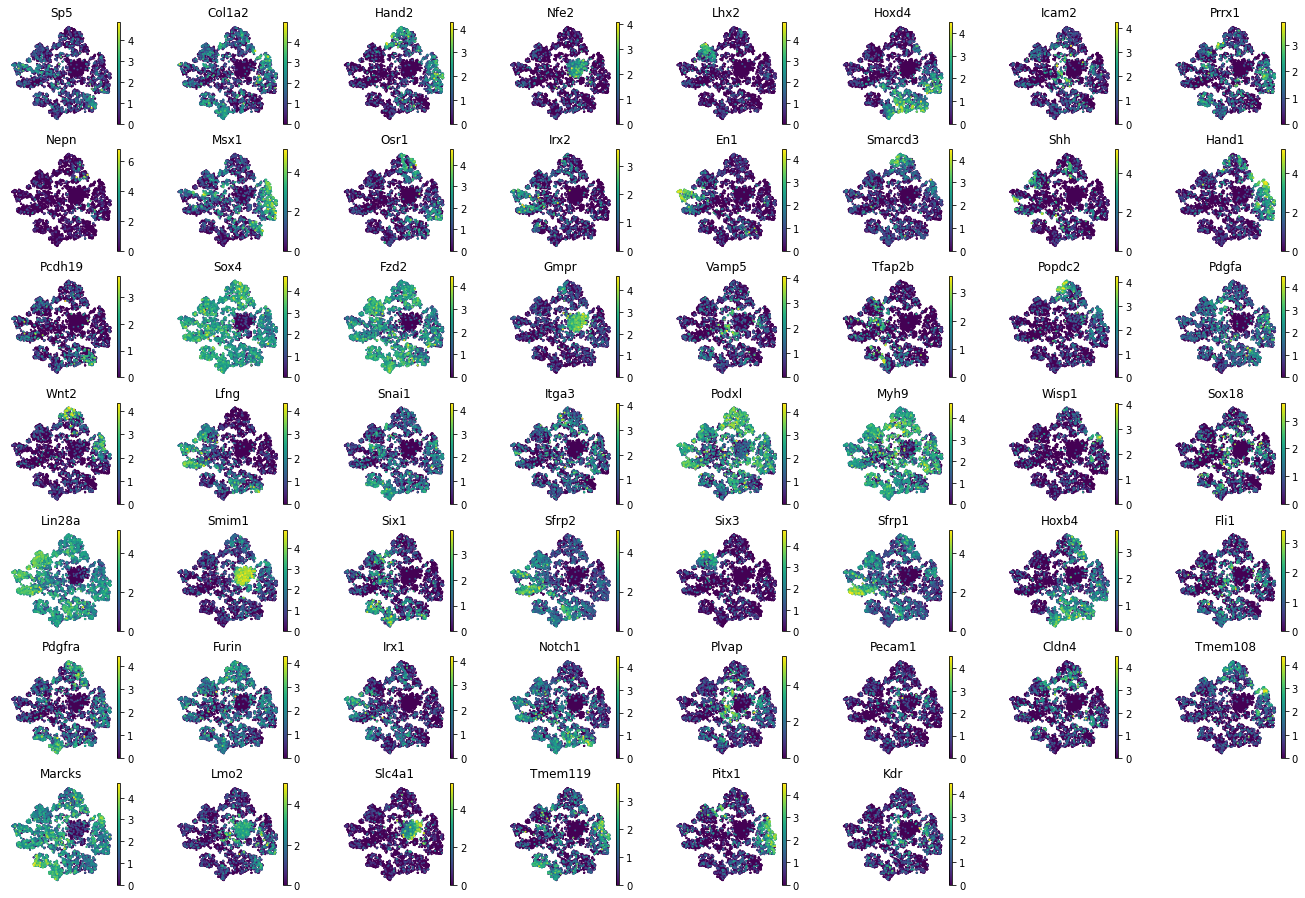

         Falling back to preprocessing with `sc.pp.pca` and default params.


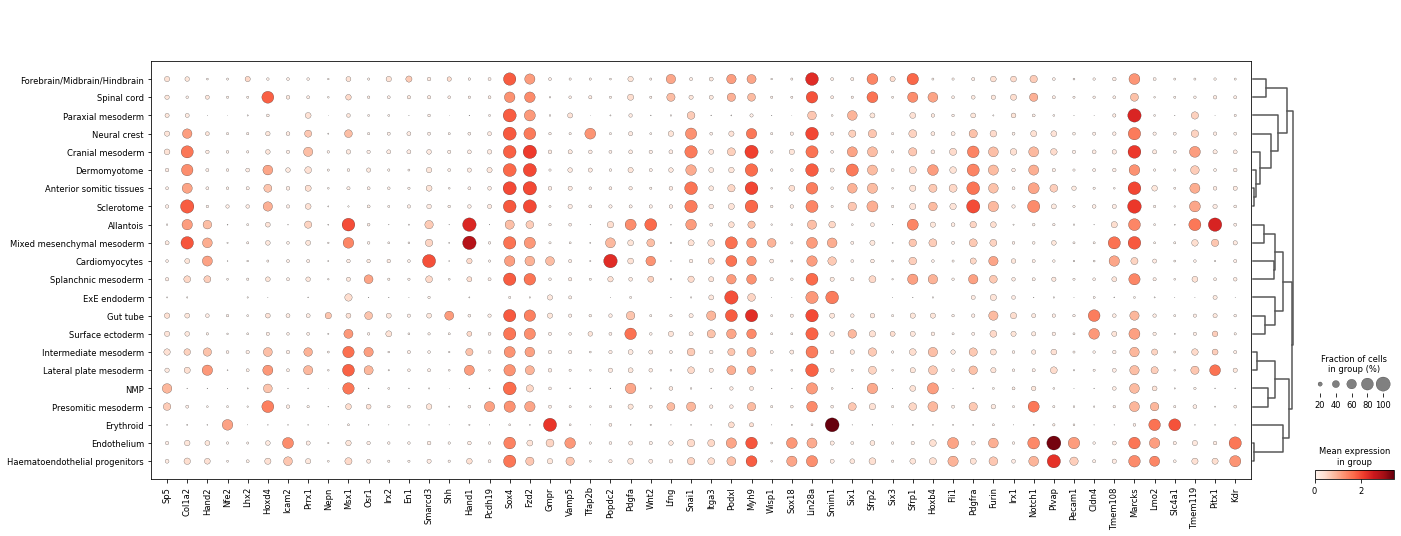

In [ ]:
adata_q.obsm['tsne'] = dist_adata.obsm['X_tsne']
with rc_context({'figure.figsize': (2, 2)}):
  sc.pl.tsne(adata_q, color=SIGs, ncols=8, legend_loc=None, frameon=False)
sc.pl.dotplot(adata_q, SIGs, groupby='cell_type', dendrogram=True)

### Mapping confidence scores
For each query cell, we additionally calculate a confidence score using Shannon’s entropy on the probability vectors, representing the degree of confidence in reconstructing the physical space:

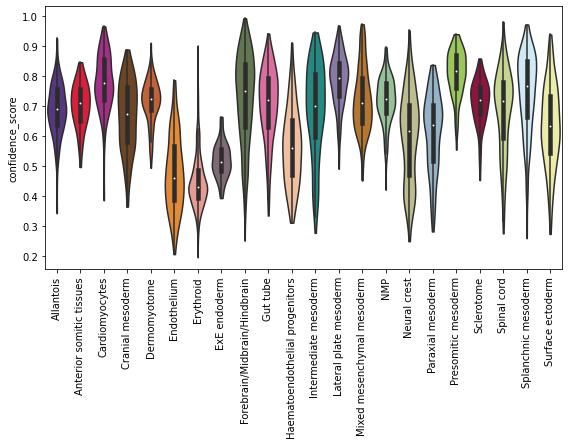

In [ ]:
adata_q.obs['confidence_score'] = (9 - (adata_q.obs['ent_seqFISH_ref1_leiden_0.05'] + adata_q.obs['ent_seqFISH_ref1_leiden_0.1'] + adata_q.obs['ent_seqFISH_ref1_leiden_0.5'] + \
                                        adata_q.obs['ent_seqFISH_ref2_leiden_0.05'] + adata_q.obs['ent_seqFISH_ref2_leiden_0.1'] + adata_q.obs['ent_seqFISH_ref2_leiden_0.5'] + \
                                        adata_q.obs['ent_seqFISH_ref3_leiden_0.05'] + adata_q.obs['ent_seqFISH_ref3_leiden_0.1'] + adata_q.obs['ent_seqFISH_ref3_leiden_0.5']))/9
with rc_context({'figure.figsize': (8, 5)}):
  sc.pl.violin(adata_q, ['confidence_score'], groupby='cell_type', palette=celltype_colours, stripplot=False, inner='box', rotation=90)